# Workshop Session 3: Global Machine Learning with MLForecast

## Welcome to Session 3 (MLForecast Edition)!

In this session, we'll explore **mlforecast** - a powerful library that simplifies global ML forecasting!

### What You'll Learn:
1. **MLForecast Library** - scalable machine learning for time series
2. **Automated Lag Features** - let the library handle feature engineering
3. **Lag Selection** - finding optimal lags via cross-validation
4. **Feature Engineering** - normalization and date features made easy
5. **Loss Function Tuning** - comparing different objectives
6. **Autoregressive Forecasting** - automatic recursive predictions

### Why MLForecast?

**Advantages over manual implementation:**
- ✅ **Automatic feature engineering** - no need to manually create lag features
- ✅ **Built-in target transformations** - normalization, differencing, etc.
- ✅ **Cross-validation support** - easy model evaluation
- ✅ **Recursive forecasting** - automatically handles multi-step predictions
- ✅ **Scalable** - works with pandas, polars, spark, dask, ray
- ✅ **Fast** - optimized implementations

Let's get started!

## 1. Setup and Imports

In [23]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# MLForecast
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences, LocalStandardScaler, LocalMinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Plotting
plt.style.use("ggplot")
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load Data and Train/Test Split

We'll use the same M5 food sales dataset from previous sessions.

In [2]:
# Load the data
data_path = "/home/filtheo/Cloud-for-AI/workshop_ml_2025/data/converted_df.csv"
df = pd.read_csv(data_path, parse_dates=["date"])

print(f"Dataset shape: {df.shape}")
print(f"Number of stores: {df['unique_id'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (12100, 3)
Number of stores: 10
Date range: 2013-01-01 00:00:00 to 2016-04-24 00:00:00

First few rows:


,unique_id,date,y
0,CA_1,2013-01-01,1888
1,CA_2,2013-01-01,1320
2,CA_3,2013-01-01,2454
3,CA_4,2013-01-01,1031
4,TX_1,2013-01-01,1607
5,TX_2,2013-01-01,2469
6,TX_3,2013-01-01,1773
7,WI_1,2013-01-01,1365
8,WI_2,2013-01-01,1506
9,WI_3,2013-01-01,1415


In [3]:
# Train/Test Split: last 14 days for testing (same as manual session 3)
test_size = 14
max_date = df["date"].max()
split_date = max_date - pd.Timedelta(days=test_size - 1)

df_train = df[df["date"] < split_date].copy()
df_test = df[df["date"] >= split_date].copy()

print(f"Train/Test Split:")
print("=" * 60)
print(f"Training set: {len(df_train):,} observations")
print(f"Test set: {len(df_test):,} observations")
print(f"\nDate ranges:")
print(f"  Train: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"  Test:  {df_test['date'].min()} to {df_test['date'].max()}")
print(f"\nForecast horizon: {test_size} days")

# Store list
stores = df["unique_id"].unique()
print(f"\nStores: {list(stores)}")

Train/Test Split:
Training set: 11,960 observations
Test set: 140 observations

Date ranges:
  Train: 2013-01-01 00:00:00 to 2016-04-10 00:00:00
  Test:  2016-04-11 00:00:00 to 2016-04-24 00:00:00

Forecast horizon: 14 days

Stores: ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']


## 3. Understanding MLForecast Data Format

**MLForecast requires:**
- `unique_id`: identifier for each time series
- `ds`: timestamp column (datestamp)
- `y`: target variable

Our data already has `unique_id` and `y`, we just need to rename `date` to `ds`!

In [4]:
# Prepare data for MLForecast
df_train_mlf = df_train.rename(columns={"date": "ds"})
df_test_mlf = df_test.rename(columns={"date": "ds"})

print("Data prepared for MLForecast:")
print("=" * 60)
print(df_train_mlf.head())
print(f"\nColumns: {list(df_train_mlf.columns)}")
print("✅ Format ready: unique_id, ds, y")

Data prepared for MLForecast:
  unique_id         ds     y
0      CA_1 2013-01-01  1888
1      CA_2 2013-01-01  1320
2      CA_3 2013-01-01  2454
3      CA_4 2013-01-01  1031
4      TX_1 2013-01-01  1607

Columns: ['unique_id', 'ds', 'y']
✅ Format ready: unique_id, ds, y


## 4. Lag Selection via Cross-Validation

### Finding Optimal Lags for Each Model

Just like in manual session 3, we'll test different `max_lags` values:
- We test: `[3, 7, 14, 21, 28]`
- For each value, MLForecast creates lags: `[1, 2, 3, ..., max_lags]`
- We find the optimal value for each model type

**Key Difference from Manual Implementation:**
- MLForecast handles feature creation automatically
- Built-in cross-validation support
- Automatic recursive forecasting

In [5]:
def cv_lag_selection_mlforecast(df_train, max_lags_candidates, model, model_name, n_folds=3, h=7):
    """
    Perform cross-validation to select optimal max_lags using MLForecast.
    
    Parameters:
    -----------
    df_train : DataFrame
        Training data with columns: ['unique_id', 'ds', 'y']
    max_lags_candidates : list
        List of max_lags values to test
    model : sklearn-like model
        Model instance to use
    model_name : str
        Name for the model (used as key in MLForecast)
    n_folds : int
        Number of CV folds
    h : int
        Validation horizon
    
    Returns:
    --------
    dict : validation MSE for each max_lags candidate
    """
    results = {}
    
    for max_lags in max_lags_candidates:
        print(f"  Testing max_lags={max_lags}...")
        
        # Create lags list: [1, 2, 3, ..., max_lags]
        lags = list(range(1, max_lags + 1))
        
        # Initialize MLForecast
        fcst = MLForecast(
            models={model_name: model},
            freq='D',
            lags=lags
        )
        
        # Perform cross-validation
        cv_results = fcst.cross_validation(
            df=df_train,
            h=h,
            n_windows=n_folds
        )
        
        # Calculate average MSE across all folds and stores
        mse = mean_squared_error(cv_results['y'], cv_results[model_name])
        results[max_lags] = mse
    
    return results

print("✅ Function created: cv_lag_selection_mlforecast()")

✅ Function created: cv_lag_selection_mlforecast()


### Find Optimal Lags for Linear Regression

In [9]:
max_lags_candidates = [7, 14, 21, 28,35]

print("Running cross-validation for Linear Regression...")
cv_results_lr = cv_lag_selection_mlforecast(
    df_train_mlf,
    max_lags_candidates,
    LinearRegression(),
    "LinearRegression",
    n_folds=3,
    h=7
)

print("\nCross-Validation Results for Linear Regression:")
print("=" * 50)
for max_lags, mse in sorted(cv_results_lr.items()):
    print(f"  max_lags={max_lags:2d} → Validation MSE: {mse:.2f}")

best_lags_lr = min(cv_results_lr, key=cv_results_lr.get)
print(f"\n✅ Optimal max_lags for Linear Regression: {best_lags_lr}")
print(f"   Validation MSE: {cv_results_lr[best_lags_lr]:.2f}")

Running cross-validation for Linear Regression...
  Testing max_lags=7...
  Testing max_lags=14...
  Testing max_lags=21...
  Testing max_lags=28...
  Testing max_lags=35...

Cross-Validation Results for Linear Regression:
  max_lags= 7 → Validation MSE: 329989.50
  max_lags=14 → Validation MSE: 282108.25
  max_lags=21 → Validation MSE: 224067.83
  max_lags=28 → Validation MSE: 156911.86
  max_lags=35 → Validation MSE: 150820.55

✅ Optimal max_lags for Linear Regression: 35
   Validation MSE: 150820.55


### Find Optimal Lags for Random Forest

In [10]:
print("Running cross-validation for Random Forest...")
cv_results_rf = cv_lag_selection_mlforecast(
    df_train_mlf,
    max_lags_candidates,
    RandomForestRegressor(),
    "RandomForest",
    n_folds=3,
    h=7
)

print("\nCross-Validation Results for Random Forest:")
print("=" * 50)
for max_lags, mse in sorted(cv_results_rf.items()):
    print(f"  max_lags={max_lags:2d} → Validation MSE: {mse:.2f}")

best_lags_rf = min(cv_results_rf, key=cv_results_rf.get)
print(f"\n✅ Optimal max_lags for Random Forest: {best_lags_rf}")
print(f"   Validation MSE: {cv_results_rf[best_lags_rf]:.2f}")

Running cross-validation for Random Forest...
  Testing max_lags=7...
  Testing max_lags=14...
  Testing max_lags=21...
  Testing max_lags=28...
  Testing max_lags=35...

Cross-Validation Results for Random Forest:
  max_lags= 7 → Validation MSE: 328051.89
  max_lags=14 → Validation MSE: 301262.77
  max_lags=21 → Validation MSE: 197816.60
  max_lags=28 → Validation MSE: 140440.36
  max_lags=35 → Validation MSE: 140845.65

✅ Optimal max_lags for Random Forest: 28
   Validation MSE: 140440.36


### Find Optimal Lags for LightGBM

In [11]:
print("Running cross-validation for LightGBM...")
cv_results_lgbm = cv_lag_selection_mlforecast(
    df_train_mlf,
    max_lags_candidates,
    lgb.LGBMRegressor(),
    "LightGBM",
    n_folds=3,
    h=7
)

print("\nCross-Validation Results for LightGBM:")
print("=" * 50)
for max_lags, mse in sorted(cv_results_lgbm.items()):
    print(f"  max_lags={max_lags:2d} → Validation MSE: {mse:.2f}")

best_lags_lgbm = min(cv_results_lgbm, key=cv_results_lgbm.get)
print(f"\n✅ Optimal max_lags for LightGBM: {best_lags_lgbm}")
print(f"   Validation MSE: {cv_results_lgbm[best_lags_lgbm]:.2f}")

Running cross-validation for LightGBM...
  Testing max_lags=7...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 11680, number of used features: 7
[LightGBM] [Info] Start training from score 2483.490668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 11750, number of used features: 7
[LightGBM] [Info] Start training from score 2485.339234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

### Visualize Lag Selection Results

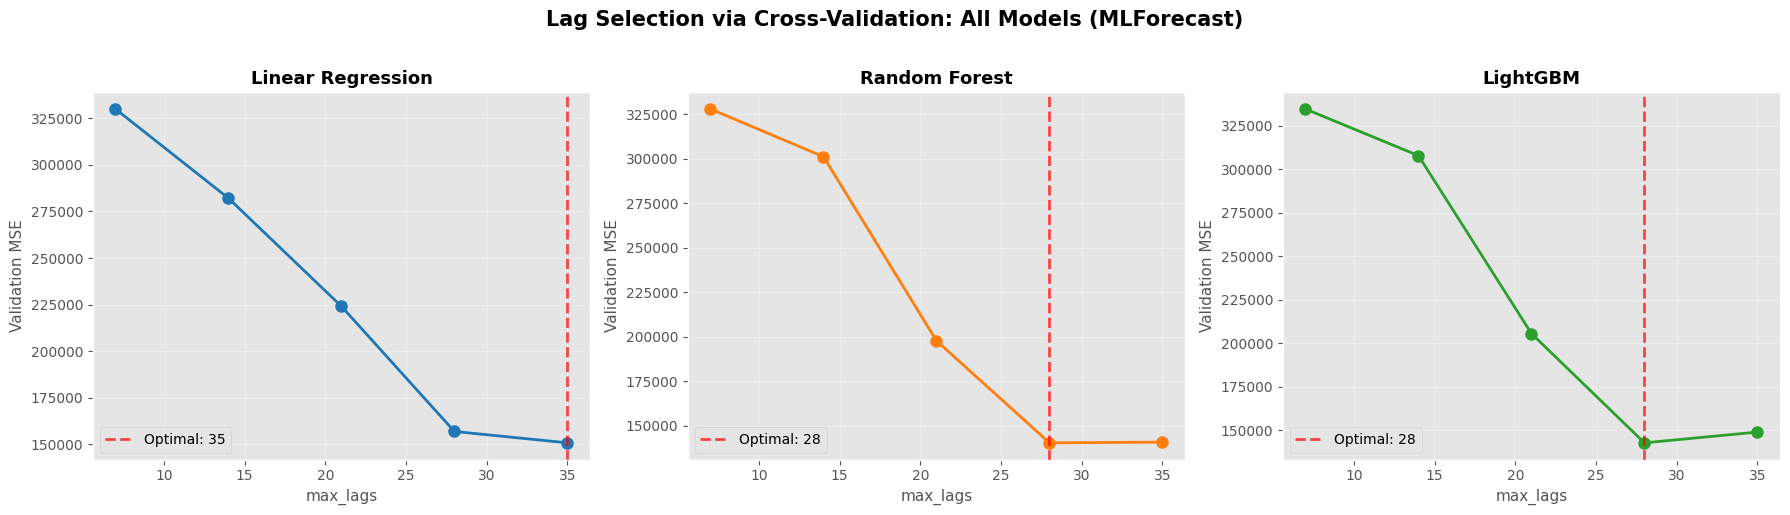


💡 Summary:
  Linear Regression optimal lags: 35
  Random Forest optimal lags: 28
  LightGBM optimal lags: 28


In [12]:
# Plot validation MSE vs max_lags for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Linear Regression
lags_list = sorted(cv_results_lr.keys())
mse_list_lr = [cv_results_lr[lag] for lag in lags_list]
axes[0].plot(
    lags_list, mse_list_lr, marker="o", linewidth=2, markersize=8, color="#1f77b4"
)
axes[0].axvline(
    x=best_lags_lr,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label=f"Optimal: {best_lags_lr}",
)
axes[0].set_xlabel("max_lags", fontsize=11)
axes[0].set_ylabel("Validation MSE", fontsize=11)
axes[0].set_title("Linear Regression", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Random Forest
mse_list_rf = [cv_results_rf[lag] for lag in lags_list]
axes[1].plot(
    lags_list, mse_list_rf, marker="o", linewidth=2, markersize=8, color="#ff7f0e"
)
axes[1].axvline(
    x=best_lags_rf,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label=f"Optimal: {best_lags_rf}",
)
axes[1].set_xlabel("max_lags", fontsize=11)
axes[1].set_ylabel("Validation MSE", fontsize=11)
axes[1].set_title("Random Forest", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# LightGBM
mse_list_lgbm = [cv_results_lgbm[lag] for lag in lags_list]
axes[2].plot(
    lags_list, mse_list_lgbm, marker="o", linewidth=2, markersize=8, color="#2ca02c"
)
axes[2].axvline(
    x=best_lags_lgbm,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label=f"Optimal: {best_lags_lgbm}",
)
axes[2].set_xlabel("max_lags", fontsize=11)
axes[2].set_ylabel("Validation MSE", fontsize=11)
axes[2].set_title("LightGBM", fontsize=13, fontweight="bold")
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle(
    "Lag Selection via Cross-Validation: All Models (MLForecast)",
    fontsize=15,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

print(f"\n💡 Summary:")
print(f"  Linear Regression optimal lags: {best_lags_lr}")
print(f"  Random Forest optimal lags: {best_lags_rf}")
print(f"  LightGBM optimal lags: {best_lags_lgbm}")

## 5. Train All Models with Their Optimal Lags

Now let's train each model with its optimal lag configuration and generate forecasts!

In [13]:
# Train all models with their optimal lags
print("Training all models with optimal lags...\n")

# Linear Regression
print(f"  Training Linear Regression (max_lags={best_lags_lr})...")
fcst_lr = MLForecast(
    models={'LinearRegression': LinearRegression()},
    freq='D',
    lags=list(range(1, best_lags_lr + 1))
)
fcst_lr.fit(df_train_mlf)
forecasts_lr = fcst_lr.predict(test_size)

# Random Forest
print(f"  Training Random Forest (max_lags={best_lags_rf})...")
fcst_rf = MLForecast(
    models={'RandomForest': RandomForestRegressor()},
    freq='D',
    lags=list(range(1, best_lags_rf + 1))
)
fcst_rf.fit(df_train_mlf)
forecasts_rf = fcst_rf.predict(test_size)

# LightGBM
print(f"  Training LightGBM (max_lags={best_lags_lgbm})...")
fcst_lgbm = MLForecast(
    models={'LightGBM': lgb.LGBMRegressor()},
    freq='D',
    lags=list(range(1, best_lags_lgbm + 1))
)
fcst_lgbm.fit(df_train_mlf)
forecasts_lgbm = fcst_lgbm.predict(test_size)

print("\n✅ All models trained and forecasted!")

Training all models with optimal lags...

  Training Linear Regression (max_lags=35)...
  Training Random Forest (max_lags=28)...
  Training LightGBM (max_lags=28)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 11680, number of used features: 28
[LightGBM] [Info] Start training from score 2492.766438

✅ All models trained and forecasted!


In [14]:
# Merge forecasts with actual test values for MSE calculation
forecasts_lr_merged = forecasts_lr.merge(df_test_mlf[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'])
forecasts_rf_merged = forecasts_rf.merge(df_test_mlf[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'])
forecasts_lgbm_merged = forecasts_lgbm.merge(df_test_mlf[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'])

# Calculate MSE for all models and stores
mse_comparison = {"Linear Regression": {}, "Random Forest": {}, "LightGBM": {}}

for store in stores:
    # Linear Regression
    lr_store = forecasts_lr_merged[forecasts_lr_merged['unique_id'] == store]
    mse_comparison["Linear Regression"][store] = mean_squared_error(
        lr_store['y'], lr_store['LinearRegression']
    )
    
    # Random Forest
    rf_store = forecasts_rf_merged[forecasts_rf_merged['unique_id'] == store]
    mse_comparison["Random Forest"][store] = mean_squared_error(
        rf_store['y'], rf_store['RandomForest']
    )
    
    # LightGBM
    lgbm_store = forecasts_lgbm_merged[forecasts_lgbm_merged['unique_id'] == store]
    mse_comparison["LightGBM"][store] = mean_squared_error(
        lgbm_store['y'], lgbm_store['LightGBM']
    )

# Print MSE comparison table
print("MSE Comparison: All Models with Optimal Lags")
print("=" * 80)
print(f"{'Store':<10} {'Linear Reg':<15} {'Random Forest':<15} {'LightGBM':<15}")
print("-" * 80)
for store in stores:
    print(
        f"{store:<10} {mse_comparison['Linear Regression'][store]:<15.2f} "
        f"{mse_comparison['Random Forest'][store]:<15.2f} {mse_comparison['LightGBM'][store]:<15.2f}"
    )

# Average across stores
print("-" * 80)
avg_lr = np.mean(list(mse_comparison["Linear Regression"].values()))
avg_rf = np.mean(list(mse_comparison["Random Forest"].values()))
avg_lgbm = np.mean(list(mse_comparison["LightGBM"].values()))
print(f"{'Average':<10} {avg_lr:<15.2f} {avg_rf:<15.2f} {avg_lgbm:<15.2f}")

MSE Comparison: All Models with Optimal Lags
Store      Linear Reg      Random Forest   LightGBM       
--------------------------------------------------------------------------------
CA_1       52289.22        16333.60        23199.65       
CA_2       110146.88       276167.34       158599.84      
CA_3       114081.95       114993.14       130160.68      
CA_4       12561.22        9648.33         10186.42       
TX_1       32106.04        48268.47        29078.03       
TX_2       78948.11        86194.51        108459.10      
TX_3       43922.35        49674.72        61848.57       
WI_1       79290.17        46951.96        60078.78       
WI_2       81404.75        143698.43       153025.90      
WI_3       24890.75        42171.84        50366.71       
--------------------------------------------------------------------------------
Average    62964.14        83410.23        78500.37       


### Visualize All Models for All Stores

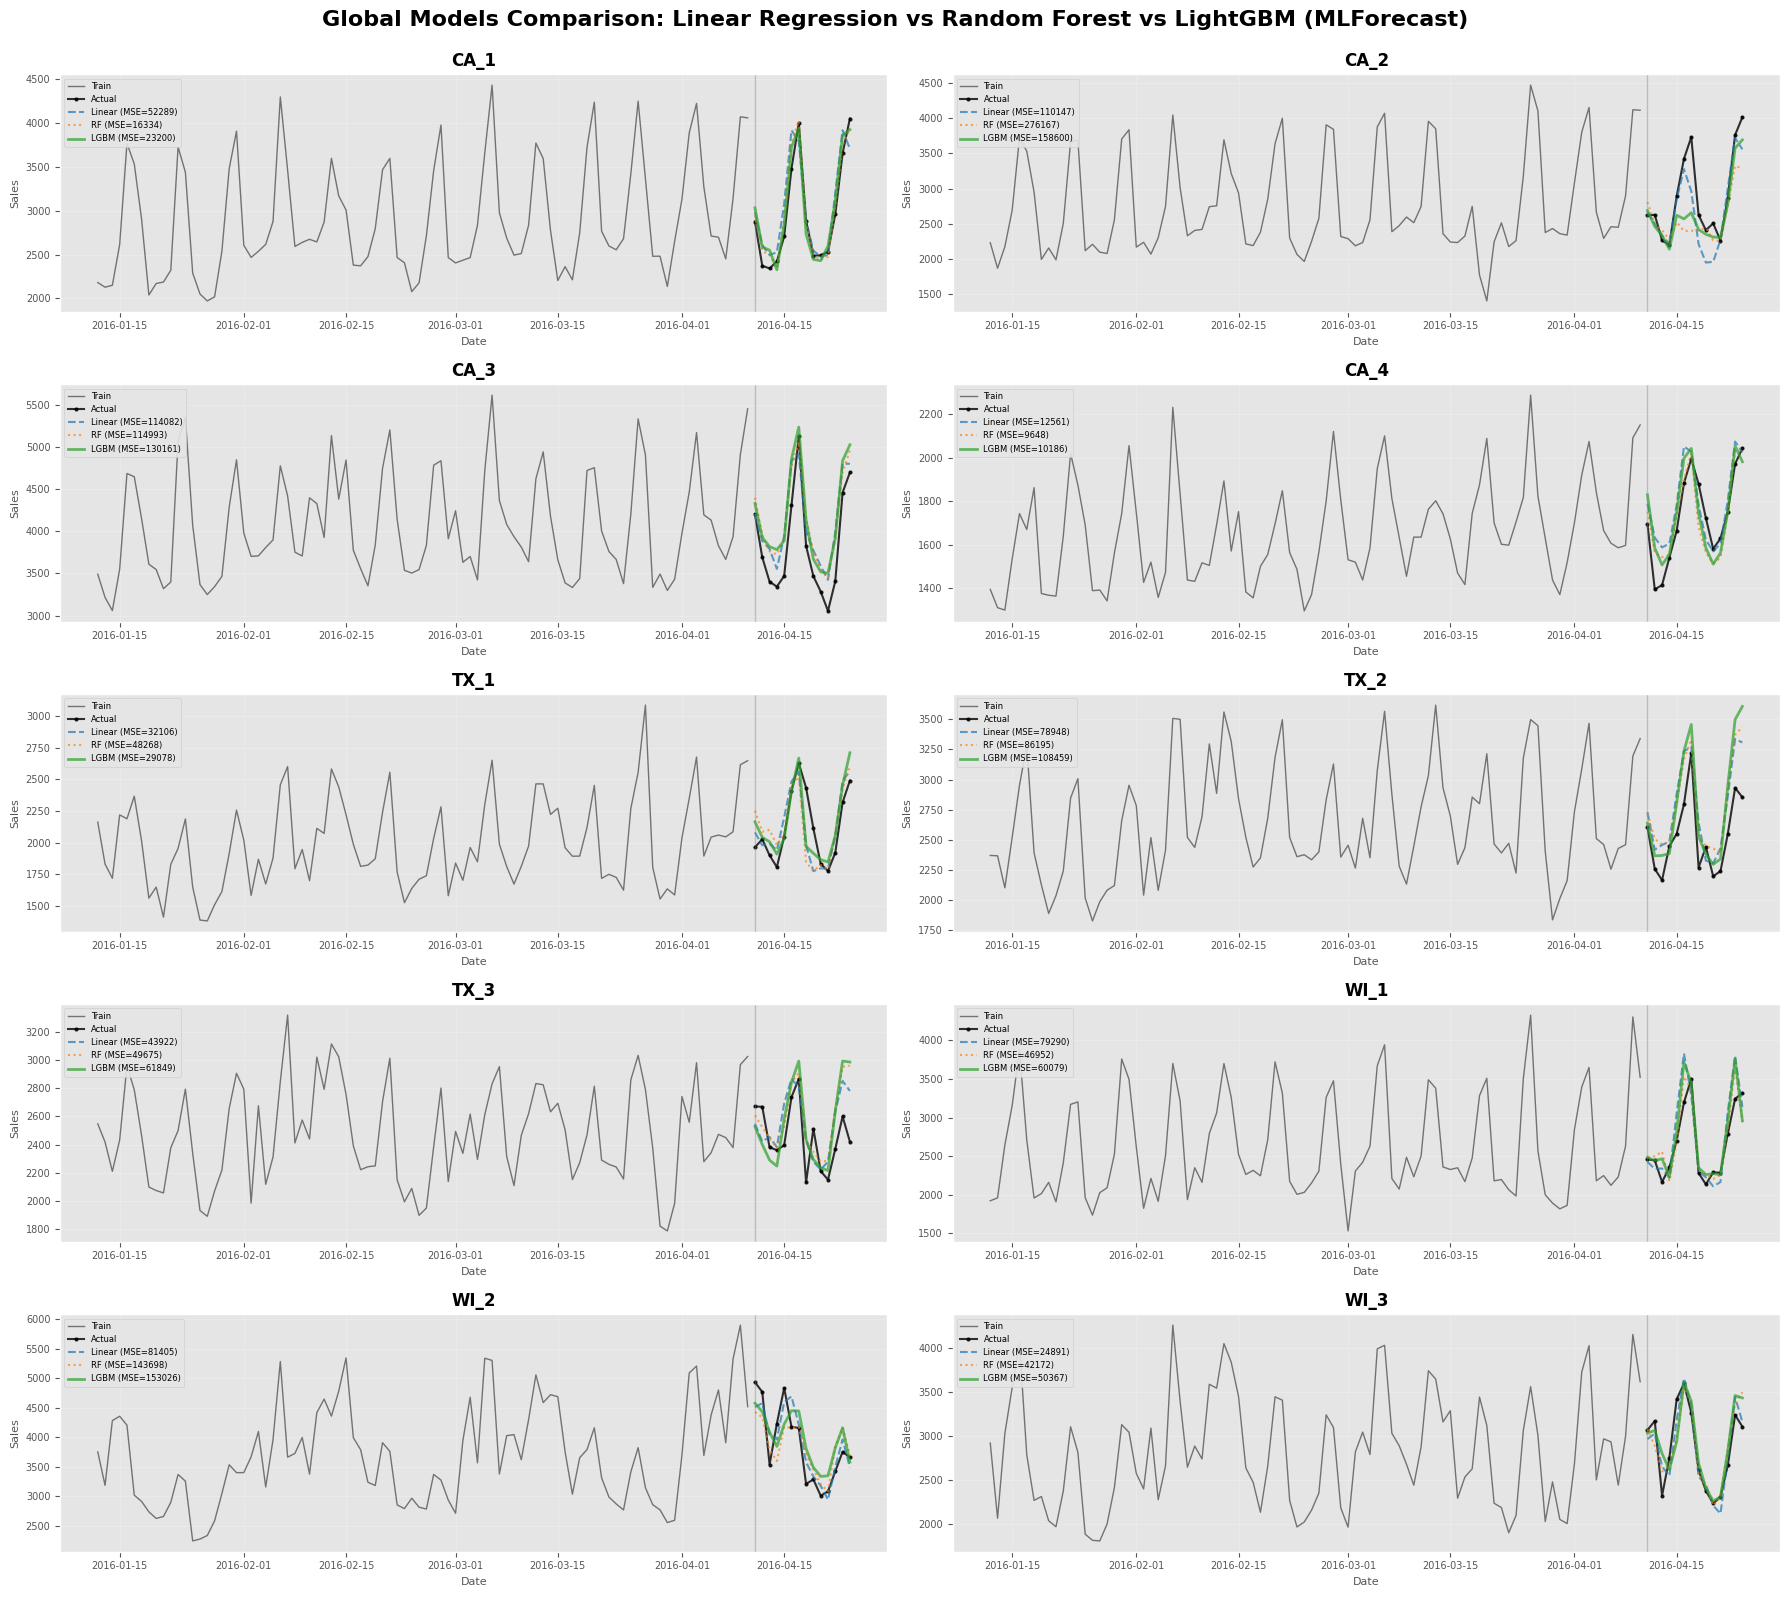


💡 Key Observations:
- Each model uses its optimal number of lags
- LightGBM (solid green) typically performs best
- MLForecast handles all feature engineering automatically!


In [15]:
# Visualize all models for all stores
fig, axes = plt.subplots(5, 2, figsize=(18, 16))
axes = axes.flatten()

model_styles = {
    "Linear Regression": {"color": "#1f77b4", "linestyle": "--", "linewidth": 1.5},
    "Random Forest": {"color": "#ff7f0e", "linestyle": ":", "linewidth": 1.5},
    "LightGBM": {"color": "#2ca02c", "linestyle": "-", "linewidth": 2},
}

for idx, store in enumerate(stores):
    train_store = df_train_mlf[df_train_mlf["unique_id"] == store].sort_values("ds")
    test_store = df_test_mlf[df_test_mlf["unique_id"] == store].sort_values("ds")

    # Plot training data (last 90 days)
    train_context = train_store.tail(90)
    axes[idx].plot(
        train_context["ds"],
        train_context["y"],
        color="black",
        linewidth=1,
        alpha=0.5,
        label="Train",
    )

    # Plot actual test data
    axes[idx].plot(
        test_store["ds"],
        test_store["y"],
        color="black",
        linewidth=1.5,
        alpha=0.8,
        marker="o",
        markersize=2,
        label="Actual",
    )

    # Plot forecasts for each model
    lr_store = forecasts_lr[forecasts_lr['unique_id'] == store].sort_values('ds')
    rf_store = forecasts_rf[forecasts_rf['unique_id'] == store].sort_values('ds')
    lgbm_store = forecasts_lgbm[forecasts_lgbm['unique_id'] == store].sort_values('ds')
    
    style = model_styles["Linear Regression"]
    mse = mse_comparison["Linear Regression"][store]
    axes[idx].plot(
        lr_store["ds"],
        lr_store['LinearRegression'],
        color=style["color"],
        linestyle=style["linestyle"],
        linewidth=style["linewidth"],
        alpha=0.7,
        label=f"Linear (MSE={mse:.0f})",
    )
    
    style = model_styles["Random Forest"]
    mse = mse_comparison["Random Forest"][store]
    axes[idx].plot(
        rf_store["ds"],
        rf_store['RandomForest'],
        color=style["color"],
        linestyle=style["linestyle"],
        linewidth=style["linewidth"],
        alpha=0.7,
        label=f"RF (MSE={mse:.0f})",
    )
    
    style = model_styles["LightGBM"]
    mse = mse_comparison["LightGBM"][store]
    axes[idx].plot(
        lgbm_store["ds"],
        lgbm_store['LightGBM'],
        color=style["color"],
        linestyle=style["linestyle"],
        linewidth=style["linewidth"],
        alpha=0.7,
        label=f"LGBM (MSE={mse:.0f})",
    )

    # Mark split
    axes[idx].axvline(x=split_date, color="gray", linestyle="-", linewidth=1, alpha=0.4)

    axes[idx].set_title(f"{store}", fontsize=12, fontweight="bold")
    axes[idx].set_xlabel("Date", fontsize=8)
    axes[idx].set_ylabel("Sales", fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.2)
    axes[idx].legend(loc="upper left", fontsize=6, framealpha=0.9)

plt.suptitle(
    "Global Models Comparison: Linear Regression vs Random Forest vs LightGBM (MLForecast)",
    fontsize=16,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("- Each model uses its optimal number of lags")
print("- LightGBM (solid green) typically performs best")
print("- MLForecast handles all feature engineering automatically!")

## 6. Feature Engineering for LightGBM

Now let's improve LightGBM's performance with feature engineering!

We'll test six configurations:
1. **Baseline**: Just lagged features (what we already did)
2. **With Normalization**: Use `LocalStandardScaler()` as target transform
3. **With MinMax Scaling**: Use `LocalMinMaxScaler()` as target transform
4. **With Date Features**: Add `dayofweek`, `day`, `week`, `is_weekend`
5. **Date Features + Scaling**: LocalStandardScaler + Date Features
6. **Date Features + MinMax**: LocalMinMaxScaler + Date Features

### Key MLForecast Features:
- **`target_transforms`**: Apply transformations to target variable (e.g., normalization)
- **`date_features`**: Automatically extract date-based features
- Both are automatically inverted during prediction!

In [27]:
# Define custom date features
def is_weekend(dates):
    return (dates.dayofweek >= 5).astype(int)

# Test different feature engineering configurations
fe_configs = {
    "Baseline (no FE)": {
        "target_transforms": None,
        "date_features": None
    },
    "With Scaling": {
        "target_transforms": [LocalStandardScaler()],
        "date_features": None
    },
    "With MinMax Scaling": {
        "target_transforms": [LocalMinMaxScaler()],
        "date_features": None
    },
    "With Date Features": {
        "target_transforms": None,
        "date_features": ['dayofweek', 'day', 'week', is_weekend]
    },
    "Date Features + Scaling": {
        "target_transforms": [LocalStandardScaler()],
        "date_features": ['dayofweek', 'day', 'week', is_weekend]
    },
    "Date Features + MinMax": {
        "target_transforms": [LocalMinMaxScaler()],
        "date_features": ['dayofweek', 'day', 'week', is_weekend]
    },
}

fe_forecasts = {}
fe_mse = {}

print("Testing feature engineering configurations for LightGBM...\n")
for config_name, config in fe_configs.items():
    print(f"  {config_name}...")
    
    # Initialize MLForecast with feature engineering
    fcst = MLForecast(
        models={'LightGBM': lgb.LGBMRegressor()},
        freq='D',
        lags=list(range(1, best_lags_lgbm + 1)),
        target_transforms=config['target_transforms'],
        date_features=config['date_features']
    )
    
    # Fit and predict
    fcst.fit(df_train_mlf)
    forecasts = fcst.predict(test_size)
    fe_forecasts[config_name] = forecasts
    
    # Calculate MSE for each store
    forecasts_merged = forecasts.merge(df_test_mlf[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'])
    fe_mse[config_name] = {}
    
    for store in stores:
        store_data = forecasts_merged[forecasts_merged['unique_id'] == store]
        mse = mean_squared_error(store_data['y'], store_data['LightGBM'])
        fe_mse[config_name][store] = mse

print("\n✅ Feature engineering comparison complete!")

Testing feature engineering configurations for LightGBM...

  Baseline (no FE)...


  With Scaling...
  With MinMax Scaling...
  With Date Features...
  Date Features + Scaling...
  Date Features + MinMax...

✅ Feature engineering comparison complete!


In [28]:
# Print MSE comparison for feature engineering
print("Feature Engineering Impact: MSE Comparison (LightGBM)")
print("=" * 145)
print(
    f"{'Store':<10} {'Baseline':<15} {'+ Scaling':<15} {'+ MinMax':<15} {'+ Date Feat':<15} {'Date+Scale':<15} {'Date+MinMax':<15}"
)
print("-" * 145)

for store in stores:
    print(f"{store:<10} ", end="")
    for config_name in fe_configs.keys():
        print(f"{fe_mse[config_name][store]:<15.2f} ", end="")
    print()

# Average across stores
print("-" * 145)
print(f"{'Average':<10} ", end="")
avg_mse_dict = {}
for config_name in fe_configs.keys():
    avg_mse = np.mean(list(fe_mse[config_name].values()))
    avg_mse_dict[config_name] = avg_mse
    print(f"{avg_mse:<15.2f} ", end="")
print()

# Find best configuration
best_config = min(avg_mse_dict, key=avg_mse_dict.get)
best_avg = avg_mse_dict[best_config]
baseline_avg = avg_mse_dict["Baseline (no FE)"]
improvement = ((baseline_avg - best_avg) / baseline_avg) * 100

print(f"\n💡 Best Configuration: {best_config}")
print(f"   Improvement: {improvement:.1f}% reduction in MSE vs baseline!")
print(f"   Baseline MSE: {baseline_avg:.2f} → Best MSE: {best_avg:.2f}")

Feature Engineering Impact: MSE Comparison (LightGBM)
Store      Baseline        + Scaling       + MinMax        + Date Feat     Date+Scale      Date+MinMax    
-------------------------------------------------------------------------------------------------------------------------------------------------
CA_1       23199.65        32896.07        29759.71        37489.61        38304.07        34579.97        
CA_2       158599.84       359048.91       207287.17       182314.27       111925.27       224854.50       
CA_3       130160.68       119900.04       120543.66       131883.67       149744.33       135576.84       
CA_4       10186.42        15556.97        14512.92        15097.66        17778.71        14807.35        
TX_1       29078.03        35148.93        33852.44        49953.94        31482.87        54853.68        
TX_2       108459.10       108247.29       114821.75       72495.14        68965.66        101512.91       
TX_3       61848.57        65912.77        68

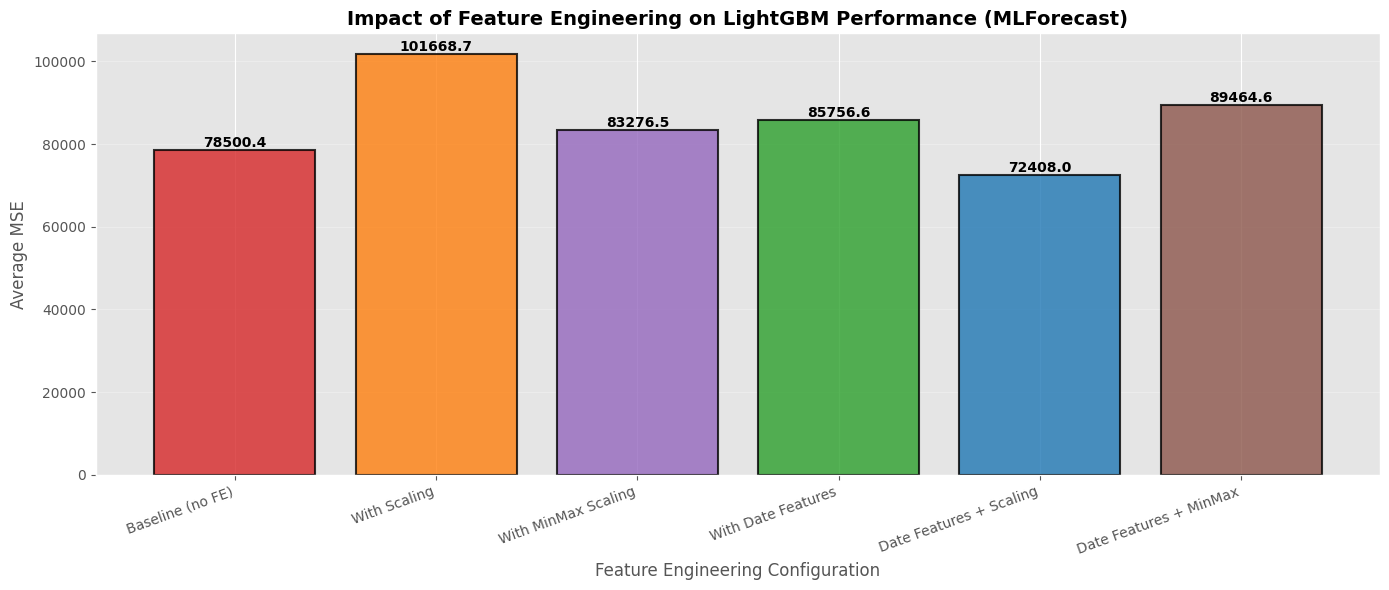

In [32]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(14, 6))

config_names = list(fe_configs.keys())
avg_mses = [np.mean(list(fe_mse[config].values())) for config in config_names]

# Color scheme for 6 configurations
colors = ["#d62728", "#ff7f0e", "#9467bd", "#2ca02c", "#1f77b4", "#8c564b"]
bars = ax.bar(
    config_names, avg_mses, color=colors, alpha=0.8, edgecolor="black", linewidth=1.5
)

# Add value labels on bars
for bar, mse in zip(bars, avg_mses):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{mse:.1f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax.set_xlabel("Feature Engineering Configuration", fontsize=12)
ax.set_ylabel("Average MSE", fontsize=12)
ax.set_title(
    "Impact of Feature Engineering on LightGBM Performance (MLForecast)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(True, alpha=0.3, axis="y")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

## 7. Loss Function Tuning for LightGBM

LightGBM supports different objective functions. Let's test which works best!

**Loss functions to test:**
- `mae` (Mean Absolute Error) - Less sensitive to outliers
- `mape` (Mean Absolute Percentage Error) - Relative error metric
- `rmse` (Root Mean Squared Error - default) - Penalizes large errors
- `huber` - Robust to outliers (hybrid of L1 and L2)

We'll use the best feature engineering configuration from previous step.

In [33]:
# Test different loss functions
loss_functions = ["mae", "mape", "rmse", "huber"]
loss_forecasts = {}
loss_mse = {}

print(f"Testing different loss functions for LightGBM with best FE config: {best_config}\n")
for loss_fn in loss_functions:
    print(f"  Training with {loss_fn}...")
    
    # Get the best feature engineering configuration
    best_fe_config = fe_configs[best_config]
    
    # Initialize MLForecast with specific loss function and best FE config
    fcst = MLForecast(
        models={'LightGBM': lgb.LGBMRegressor(
            objective=loss_fn,
            random_state=42,
            verbose=-1
        )},
        freq='D',
        lags=list(range(1, best_lags_lgbm + 1)),
        target_transforms=best_fe_config['target_transforms'],
        date_features=best_fe_config['date_features']
    )
    
    # Fit and predict
    fcst.fit(df_train_mlf)
    forecasts = fcst.predict(test_size)
    loss_forecasts[loss_fn] = forecasts
    
    # Calculate MSE for each store
    forecasts_merged = forecasts.merge(df_test_mlf[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'])
    loss_mse[loss_fn] = {}
    
    for store in stores:
        store_data = forecasts_merged[forecasts_merged['unique_id'] == store]
        mse = mean_squared_error(store_data['y'], store_data['LightGBM'])
        loss_mse[loss_fn][store] = mse

print("\n✅ Loss function comparison complete!")

Testing different loss functions for LightGBM with best FE config: Date Features + Scaling

  Training with mae...


  Training with mape...
  Training with rmse...
  Training with huber...

✅ Loss function comparison complete!


In [34]:
# Print MSE comparison for loss functions
print("Loss Function Impact: MSE Comparison (LightGBM with Full FE)")
print("=" * 90)
print(f"{'Store':<10} {'mae':<20} {'mape':<20} {'rmse':<20} {'huber':<20}")
print("-" * 90)

for store in stores:
    print(f"{store:<10} ", end="")
    for loss_fn in loss_functions:
        print(f"{loss_mse[loss_fn][store]:<20.2f} ", end="")
    print()

# Average across stores
print("-" * 90)
print(f"{'Average':<10} ", end="")
avg_loss_mse = {}
for loss_fn in loss_functions:
    avg_mse = np.mean(list(loss_mse[loss_fn].values()))
    avg_loss_mse[loss_fn] = avg_mse
    print(f"{avg_mse:<20.2f} ", end="")
print()

# Find best loss function
best_loss = min(avg_loss_mse, key=avg_loss_mse.get)
print(f"\n✅ Best loss function: {best_loss}")
print(f"   Average MSE: {avg_loss_mse[best_loss]:.2f}")

Loss Function Impact: MSE Comparison (LightGBM with Full FE)
Store      mae                  mape                 rmse                 huber               
------------------------------------------------------------------------------------------
CA_1       34844.60             38896.00             38304.07             56239.05             
CA_2       165577.78            289006.19            111925.27            109990.93            
CA_3       119841.73            149276.50            149744.33            177332.41            
CA_4       13811.89             17354.00             17778.71             19269.38             
TX_1       38828.46             38052.88             31482.87             37807.68             
TX_2       57738.14             57047.47             68965.66             69049.63             
TX_3       40814.18             34032.66             57975.68             48776.14             
WI_1       24057.07             47338.01             33523.92             34953.8

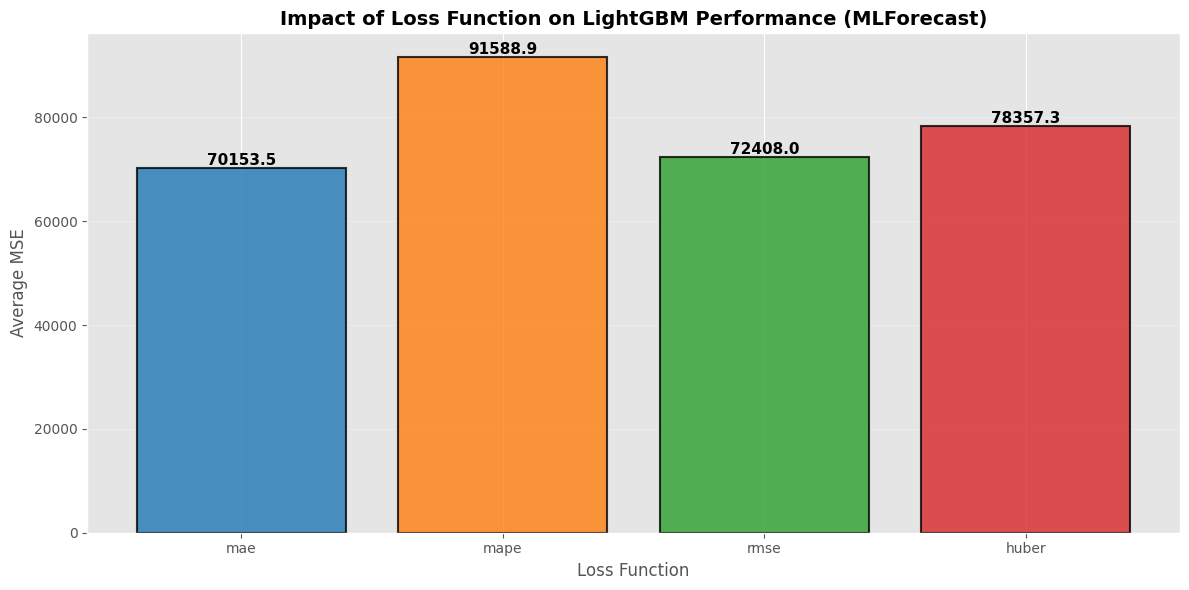

In [21]:
# Bar chart for loss function comparison
fig, ax = plt.subplots(figsize=(12, 6))

loss_names = loss_functions
avg_mses = [avg_loss_mse[loss] for loss in loss_names]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
bars = ax.bar(
    loss_names, avg_mses, color=colors, alpha=0.8, edgecolor="black", linewidth=1.5
)

# Add value labels on bars
for bar, mse in zip(bars, avg_mses):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{mse:.1f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

ax.set_xlabel("Loss Function", fontsize=12)
ax.set_ylabel("Average MSE", fontsize=12)
ax.set_title(
    "Impact of Loss Function on LightGBM Performance (MLForecast)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

## 8. Final Comparison and Summary

Let's visualize the best configuration (LightGBM with best loss function + best FE config) for all stores!

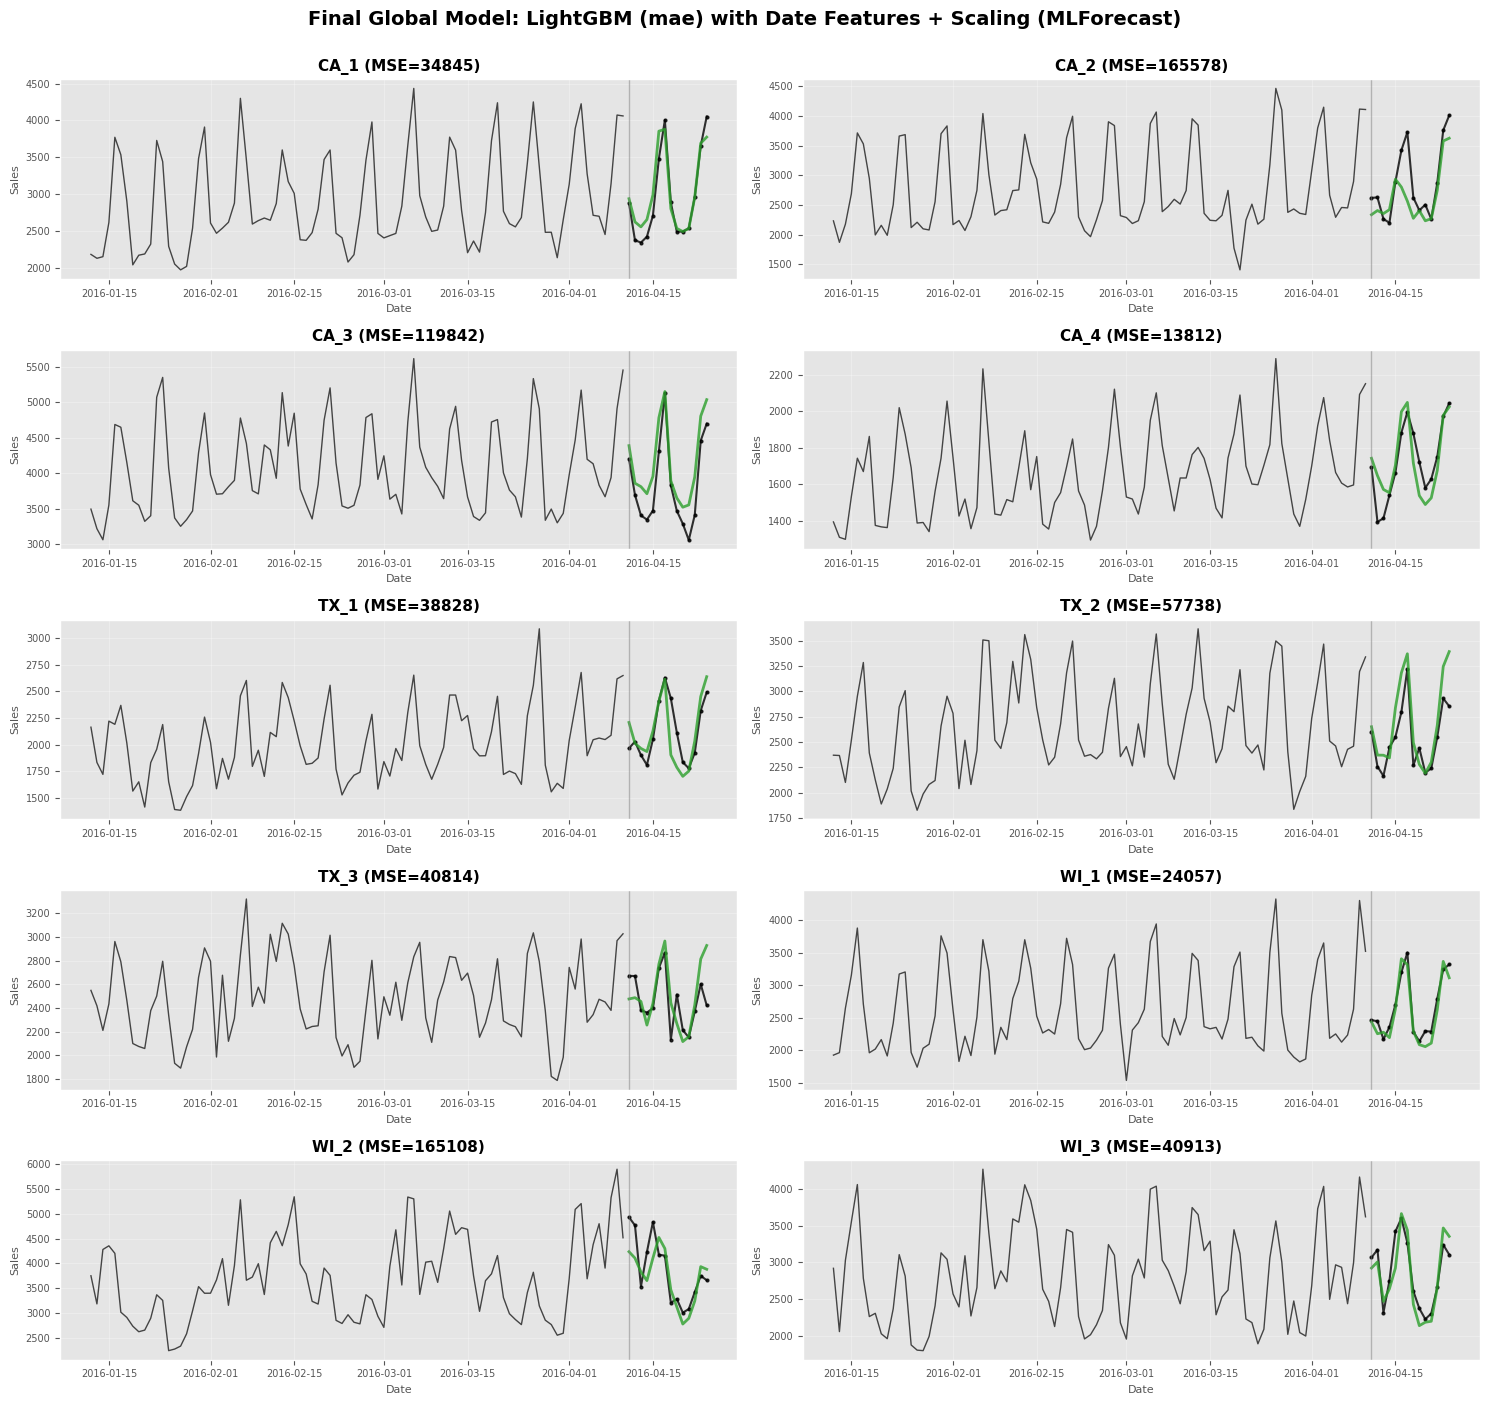


✅ Final Model Performance:
   Average MSE across all stores: 70153.49
   Model: LightGBM with mae loss
   Features: Date Features + Scaling
   Optimal lags: 28


In [35]:
# Visualize final best model for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

best_forecasts = loss_forecasts[best_loss].merge(
    df_test_mlf[['unique_id', 'ds', 'y']], on=['unique_id', 'ds']
)

for idx, store in enumerate(stores):
    train_store = df_train_mlf[df_train_mlf["unique_id"] == store].sort_values("ds")
    test_store = df_test_mlf[df_test_mlf["unique_id"] == store].sort_values("ds")
    forecast_store = best_forecasts[best_forecasts["unique_id"] == store].sort_values("ds")

    # Plot
    train_context = train_store.tail(90)
    axes[idx].plot(
        train_context["ds"], train_context["y"], color="black", linewidth=1, alpha=0.7
    )
    axes[idx].plot(
        test_store["ds"],
        test_store["y"],
        color="black",
        linewidth=1.5,
        alpha=0.8,
        marker="o",
        markersize=2,
    )
    axes[idx].plot(
        forecast_store["ds"],
        forecast_store['LightGBM'],
        color="#2ca02c",
        linewidth=2,
        linestyle="-",
        alpha=0.8,
    )
    axes[idx].axvline(x=split_date, color="gray", linestyle="-", linewidth=1, alpha=0.5)

    # Calculate MSE
    mse = loss_mse[best_loss][store]

    axes[idx].set_title(f"{store} (MSE={mse:.0f})", fontsize=11, fontweight="bold")
    axes[idx].set_xlabel("Date", fontsize=8)
    axes[idx].set_ylabel("Sales", fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle(
    f"Final Global Model: LightGBM ({best_loss}) with {best_config} (MLForecast)",
    fontsize=14,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.show()

avg_mse_final = avg_loss_mse[best_loss]
print(f"\n✅ Final Model Performance:")
print(f"   Average MSE across all stores: {avg_mse_final:.2f}")
print(f"   Model: LightGBM with {best_loss} loss")
print(f"   Features: {best_config}")
print(f"   Optimal lags: {best_lags_lgbm}")

## 9. Summary and Key Takeaways

### What We Learned in Session 3 (MLForecast Edition):

#### 1. **MLForecast Library**
- Powerful library for scalable ML forecasting
- Handles feature engineering automatically
- Built-in support for target transformations
- Easy cross-validation and model evaluation

#### 2. **Automated Lag Features**
- Simply specify `lags` parameter
- No need to manually create lagged features
- Supports continuous lag ranges

#### 3. **Lag Selection via Cross-Validation**
- Used `cross_validation()` method
- Tested candidates: [3, 7, 14, 21, 28]
- Found optimal lags for each model

#### 4. **Feature Engineering Made Easy**
- **Normalization**: `target_transforms=[LocalStandardScaler()]`
- **Date Features**: `date_features=['dayofweek', 'day', 'week', ...]`
- Automatic inverse transformation during prediction!

#### 5. **Loss Function Tuning**
- Tested: `mae`, `mape`, `rmse`, `huber`
- Different objectives for different data characteristics
- Easy to specify via model parameters

#### 6. **Autoregressive Forecasting**
- Simply call `predict(h)` for multi-step forecasts
- Automatic recursive prediction
- No need to manually update features

### MLForecast vs Manual Implementation:

| Aspect | Manual Implementation | MLForecast |
|--------|----------------------|------------|
| Lag Feature Creation | Manual loops | Automatic via `lags` |
| Target Transforms | Manual scaling | Built-in `target_transforms` |
| Date Features | Manual extraction | Automatic via `date_features` |
| Recursive Forecasting | Manual implementation | Automatic via `predict()` |
| Cross-Validation | Custom function | Built-in `cross_validation()` |
| Code Length | ~500 lines | ~100 lines |

### Key Principles:

1. **Automation saves time** - let the library handle boilerplate
2. **Feature engineering matters** - normalization + date features boost performance
3. **Model-specific tuning** - find optimal lags for each algorithm
4. **Loss function selection** - choose based on data characteristics
5. **MLForecast is production-ready** - scalable and well-tested

---

### 🎓 Congratulations!

You've completed Session 3 (MLForecast Edition) of the Time Series Forecasting Workshop. You now understand:
- How to use MLForecast for global ML models
- Automated feature engineering
- Model optimization and tuning
- Production-ready forecasting workflows

**Key Advantage**: You can now build the same models with much less code and built-in best practices! 🚀